Imports


In [530]:
# Install haversine if required
#!pip install haversine

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import geopy.distance
import haversine as hs
from haversine import Unit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from tkinter import filedialog

Load data


In [531]:
# Load dataset
file_path = filedialog.askopenfilename(title="Select the CSV file")

df = pd.read_csv(file_path)


Drop column 1 and 2

In [532]:
# Remove unnecessary columns
df.drop(['key','Unnamed: 0'], axis=1, inplace=True)
df.dropna(axis=0,inplace=True)

In [533]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())



Missing values in the dataset:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [534]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

print('\r\n')

# Display the columns of the dataset
print("Fields of the dataset:")
print(df.columns)

First few rows of the dataset:
   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1          7.7  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2         12.9  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3          5.3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4         16.0  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5  


Fields of the dataset:
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',

Extract hours from date time

In [535]:
# Convert 'pickup_datetime' to a datetime data type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the date, time, and other components
df['Hour'] = df['pickup_datetime'].dt.hour


In [536]:
df.drop('pickup_datetime', axis=1, inplace=True)



Remove latitude and longitude values not in range

In [537]:
#Drop the rows where the latitude and longitude are not in range
condition = df[
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
].index
df.drop(condition, inplace=True)

Calculate Distance

In [538]:
#Calculate the distance between pickup and dropoffm
longitude, latitude = [], []

longitude.append(df["pickup_longitude"].tolist())
longitude.append(df["dropoff_longitude"].tolist())
latitude.append(df["pickup_latitude"].tolist())
latitude.append(df["dropoff_latitude"].tolist())

#Find the distance in miles
distance = [hs.haversine((latitude[1][i], longitude[1][i]), (latitude[0][i], longitude[0][i]), unit=Unit.MILES)
              for i in range(len(longitude[0]))]

#Append the new distance column to the dataset
df['distance'] = distance

In [539]:

df.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] , inplace=True , axis= 1)
df.head()

,fare_amount,passenger_count,Hour,distance
0,7.5,1,19,1.045970
1,7.7,1,20,1.527078
2,12.9,1,21,3.129464
3,5.3,3,8,1.032524
4,16.0,5,17,2.780920


Remove Outliers

In [540]:
#Drop the rows where the fare amount is <=0 and distance is <=0

df.drop(df[df['fare_amount']<=0].index,inplace=True)
df.drop(df[df['distance']<=0].index,inplace=True)
df.drop(df[df['distance']>60].index,inplace=True)

#drop outlier distance and fair amount
df.drop(df[df['distance']>100].index,inplace=True)
df.drop(df[df['fare_amount']>100].index,inplace=True)

#drop unrealistic fair amounts and distance travelled
df.drop(df[(df['fare_amount']>=100) & (df['distance']<=1)].index,inplace=True)
df.drop(df[(df['fare_amount']<=100) & (df['distance']>=100)].index,inplace=True)


Distance vs fare amount graph

Text(0, 0.5, 'fare_amount')

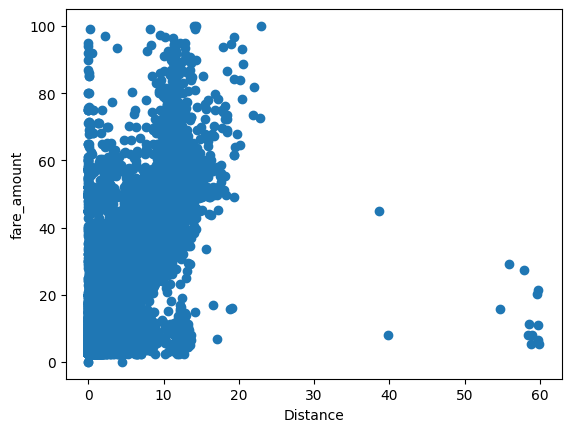

In [541]:
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [542]:
x = df.drop(['fare_amount'],axis = 1)
y = df['fare_amount'].values.reshape(-1, 1)

In [543]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

Standardize values

In [544]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [545]:
# Model Evaluation
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=42)

In [546]:
# Create linear model and train
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

y_pred = LR.predict(x_test)

Accuracy Metrics

In [547]:

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)


print("Root Mean Squared Error:", rmse)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)



Mean Squared Error: 0.28104491316812347
Root Mean Squared Error: 0.5301366929086531
Mean Absolute Error: 0.25390222691781433
R-squared: 0.7290310076292887


Actual values and predicted values table

In [548]:
y_pred = LR.predict(x_test)
df = {'Actual': y_test, 'Predicted': y_pred}

from tabulate import tabulate
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+--------------+--------------+
|       Actual |    Predicted |
|--------------+--------------|
| -0.256346    |  0.000872264 |
| -0.138818    | -0.605437    |
|  0.395404    | -0.12203     |
| -0.566195    | -0.322116    |
| -0.341822    | -0.218486    |
|  0.448826    |  0.47105     |
|  0.235137    | -0.245752    |
| -0.128133    | -0.356546    |
|  0.598408    |  1.52072     |
| -0.854675    | -0.699147    |
| -0.256346    |  0.0889235   |
| -0.598248    | -0.481511    |
| -0.256346    |  0.096128    |
| -0.299084    | -0.0566881   |
|  0.0214488   | -0.389294    |
| -0.0853955   | -0.13887     |
| -0.811937    | -0.697393    |
|  0.395404    |  0.563821    |
| -0.0853955   | -0.153215    |
| -0.341822    | -0.181419    |
| -0.619617    | -0.315782    |
| -0.470035    | -0.42684     |
| -0.405929    | -0.27204     |
|  0.256506    |  0.373415    |
| -0.673039    | -0.576667    |
|  0.256506    |  0.361221    |
| -0.256346    | -0.585048    |
| -0.619617    | -0.683589    |
| -0.726

Actual vs predicted graph

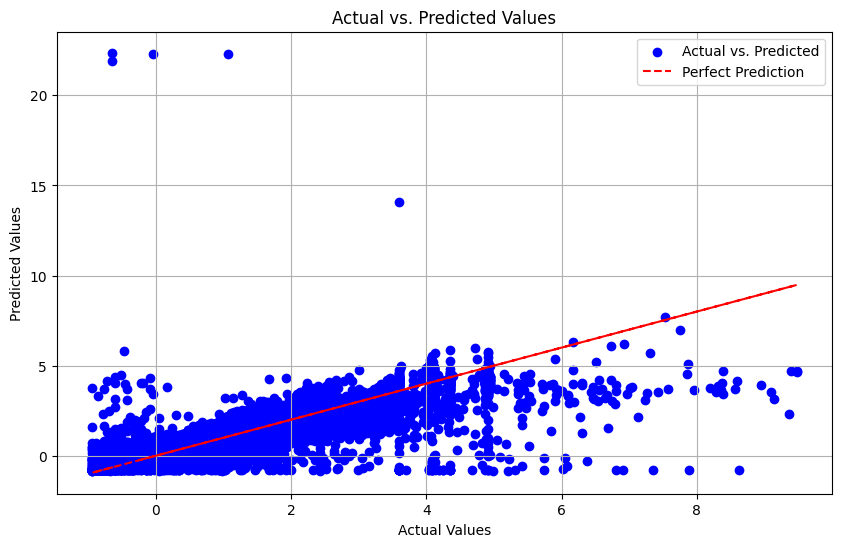

In [549]:
# Plotting the actual vs. predicted values with different colors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')  # Plotting the perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()